<h1>CI HW4<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Q1" data-toc-modified-id="Q1-1">Q1</a></span></li><li><span><a href="#Q2" data-toc-modified-id="Q2-2">Q2</a></span><ul class="toc-item"><li><span><a href="#Stepwise-Regression-for-Variable-Selection" data-toc-modified-id="Stepwise-Regression-for-Variable-Selection-2.1">Stepwise Regression for Variable Selection</a></span></li><li><span><a href="#GA-for-Variable-Selection" data-toc-modified-id="GA-for-Variable-Selection-2.2">GA for Variable Selection</a></span></li><li><span><a href="#ACO-for-Variable-Selection" data-toc-modified-id="ACO-for-Variable-Selection-2.3">ACO for Variable Selection</a></span></li><li><span><a href="#PSO-for-Variable-Selection" data-toc-modified-id="PSO-for-Variable-Selection-2.4">PSO for Variable Selection</a></span></li></ul></li><li><span><a href="#Q3-Discussion" data-toc-modified-id="Q3-Discussion-3">Q3 Discussion</a></span></li></ul></div>

## Q1

Tao's Vanilla Benchmark Model is as follows:

$$Load=\beta_{0}+\beta_{1}Trend+\beta_{2}Weekday*Hour+\beta_{3}Month+\beta_{4}Month*T+\beta_{5}Month*T^2+\beta_{6}Month*T^3+\beta_{7}Hour*T+\beta_{8}Hour*T^2+\beta_{9}Hour*T^3$$

There are `290` parameters to be estimated in total for this model, of which `285` are non-zero parameters and `5` are zero parameters. The details are shown in the table below:

| Variable Name| Variable Type | # of Parameters | Comments |
|:--- |:--- |:---:|:---|
| Intercept ($\beta_0$) | Quantitative | 1 | 1 non-zero parameter |
| Trend ($\beta_1$) | Quantitative | 1 | 1 non-zero parameter |
| Hour * Weekday ($\beta_2$) | Qualitative | 168 | 167 non-zero parameters and 1 zero parameter |
| Month ($\beta_3$) | Qualitative | 12 | 11 non-zero parameters and 1 zero parameter |
| $T$ * Month ($\beta_{4}$) | Qualitative | 12 | 11 + 1 = 12 non-zero parameters. The +1 is for the $T$ term. |
| $T^2$ * Month ($\beta_{5}$) | Qualitative | 12 | 11 + 1 = 12 non-zero parameters. The +1 is for the $T^2$ term. |
| $T^3$ * Month ($\beta_{6}$) | Qualitative | 12 | 11 + 1 = 12 non-zero parameters. The +1 is for the $T^3$ term. |
| $T$ * Hour ($\beta_7$) | Qualitative | 24 | 23 non-zero parameters and 1 zero parameter. Note that the $T$ has been added in the previous term. |
| $T^2$ * Hour ($\beta_{8}$) | Qualitative | 24 | 23 non-zero parameters and 1 zero parameter. Note that the $T^2$ has been added in the previous term.  |
| $T^3$ * Hour ($\beta_{9}$) | Qualitative | 24 | 23 non-zero parameters and 1 zero parameter. Note that the $T^3$ has been added in the previous term.  |


## Q2

Here the aggregated zone ($Z_{21}$) has been chosen for the design of experiments below. The average temperature series from the 11 weather stations have been used as the temperature variable in the Tao's vanilla benchmark model.

The MAPE on the validation period is `5.221%` if all the 285 variables are included in the model. 

### Stepwise Regression for Variable Selection

The stepwise regression selects the variables by successively adding or removing variables based on the criterions (here's the MAPE on the validation period). The model will start with `Intercept` as the only variable. At each step, a variable will be added to the model based on the MAPE improvement on the validation set. Then, we'll try to remove a variable from the model based on the MAPE improvement the removal can bring in. This variable selection process will last until the model becomes unchanged throughout a stepwise iteration.

Below gives the implementation of stepwise regression. We can tell the variable selection stops after 16 iterations, when the forward and backward selection won't improve the model MAPE after 16th iteration. 

There are `13` variables being selected out of 285 variables, giving the MAPE=`8.955%` on the validation period (2007). The variables being selected are: Intercept, month=2, 8 dummy variables, month=8 interaction with $T^3$, month=2 interaction with $T$, hour=6 dummy variable, 4 hour dummy variables (hour=2, 3, 4, 5) interaction with $T$; $T$; $T^3$; hour=21 interaction with $T^3$.

In [4]:
%matplotlib notebook
import numpy as np
import pandas as pd
import statsmodels.api as sm
import patsy
import sys
from macros import add_trend, MAPE

user = 'Administrator'
sys.path.insert(1, 'C:/Users/' + user + '/PycharmProjects/MyTest/')

# %% Q2
# Import and Data Preprocessing
Training = [2005, 2006]
Validation = 2007
zoneID = 21

if user == 'Administrator':
    load = pd.read_sas(r'C:\Users\Administrator\Dropbox\Thesis code\SAS Library Files 2012\load_temp.sas7bdat')
else:
    load = pd.read_sas(r'D:\Yike Li Thesis folder\SAS Library Files 2012\load_temp.sas7bdat')
load = load.astype(int)  # convert all nums to int
load['date'] = pd.to_datetime(load['year'].astype(str) + '-' + load['month'].astype(str) + '-' + load[
    'day'].astype(str) + '-' + (load['hour'] - 1).astype(str), format='%Y-%m-%d-%H')  # create date col

zone_21 = load.iloc[np.where((load['zone_id'] == zoneID))]  # For zone 21
zone_21 = add_trend(zone_21)  # add trend var
T_cols = ['T' + str(n) for n in range(1, 11 + 1)]
zone_21['T'] = zone_21[T_cols].mean(axis=1) # create new col T=average temp
zone_21 = zone_21.drop(T_cols, axis=1)  # drop individual temps

# Get the design matrix of the Vanilla model
zone21_train = zone_21[zone_21['year'].isin(Training)]
zone21_val = zone_21[zone_21['year'] == Validation]

f = 'load ~ trend + C(hour) * C(weekday) + C(month) + C(month) * T + C(month) * I(T ** 2) + ' \
    'C(month) * I(T ** 3) + C(hour) * T + C(hour) * I(T ** 2) + C(hour) * I(T ** 3)'
y_train, X_train = patsy.dmatrices(f, zone21_train, return_type='dataframe')  # training
y_val, X_val = patsy.dmatrices(f, zone21_val, return_type='dataframe')  # validation

# MAPE with all vars
model = sm.OLS(y_train, X_train).fit()
print(MAPE(y_val, model.predict(X_val)))


def stepwise_regression():
    var_pool = list(X_train.columns)
    var_model = [var_pool.pop(0)]  # initialize, has only Intercept as the variable. Remove Intercept from var_pool.
    X_old = X_train[var_model]
    model = sm.OLS(y_train, X_old).fit()
    mape_old = MAPE(y_val, model.predict(X_val[var_model]))  # eval the old

    for count in range(1, len(X_train.columns) + 1):
        stop_count = 0  # when stop_count = 2, break the entire loop
        # Forward selection
        mape_list = []  # clean up the mape_list
        for i in var_pool:  # go through each element in var_pool
            X = X_train[var_model + [i]]
            model = sm.OLS(y_train, X).fit()
            mape = MAPE(y_val, model.predict(X_val[var_model + [i]]))
            mape_list.append(mape)

        min_mape_idx = mape_list.index(min(mape_list))  # retrieve the index results in best performance
        if mape_list[min_mape_idx] < mape_old:  # if forward selection shows improvement
            var_model = var_model + [var_pool.pop(min_mape_idx)]  # pop the var_pool, update var_model
            print('Iteration=', count, ', Forward selection improves result, mape is', mape_list[min_mape_idx])
            mape_old = mape_list[min_mape_idx]  # refresh the mape_old
        else:
            print('Iteration=', count, ', Forward selection has no improvement')
            stop_count += 1
        # Backward selection
        if count >= 2:  # starting from 2nd iteration
            mape_list = []  # clean up the mape_list
            for i in var_model[1:-1]:  # enumerate from the 2nd element to the 2nd last element
                idx = var_model.index(i)  # return the index of i
                X = X_train[var_model[:idx] + var_model[idx + 1:]]  # remove the index=i element
                model = sm.OLS(y_train, X).fit()
                mape = MAPE(y_val, model.predict(X_val[var_model[:idx] + var_model[idx + 1:]]))
                mape_list.append(mape)

            min_mape_idx = mape_list.index(min(mape_list))  # retrieve the index results in best performance
            if mape_list[min_mape_idx] < mape_old:  # if backward (removing one element) shows improvement
                var_pool = var_pool + [var_model.pop(min_mape_idx)]  # remove ele in var_model, add ele back to var_pool
                print('Iteration=', count, ', Backward selection improves result, mape is', mape_list[min_mape_idx])
                mape_old = mape_list[min_mape_idx]  # refresh the mape_old
            else:
                print('Iteration=', count, ', Backward selection has no improvement')
                stop_count += 1

        if stop_count == 2:  # if forward+backward show no improvement, break the loop
            break
    return var_model


var_selected = stepwise_regression()
print('\nThere are', len(var_selected), 'variables being selected.')
print('\nThe variables being selected are:', var_selected)


Iteration= 1 , Forward selection improves result, mape is 18.051941746418727
Iteration= 2 , Forward selection improves result, mape is 17.446089266180056
Iteration= 2 , Backward selection has no improvement
Iteration= 3 , Forward selection improves result, mape is 16.77568883742823
Iteration= 3 , Backward selection has no improvement
Iteration= 4 , Forward selection improves result, mape is 16.21057137516981
Iteration= 4 , Backward selection has no improvement
Iteration= 5 , Forward selection improves result, mape is 15.697278558970234
Iteration= 5 , Backward selection has no improvement
Iteration= 6 , Forward selection improves result, mape is 14.933272256845326
Iteration= 6 , Backward selection has no improvement
Iteration= 7 , Forward selection improves result, mape is 14.508660309928509
Iteration= 7 , Backward selection has no improvement
Iteration= 8 , Forward selection improves result, mape is 14.129436244775256
Iteration= 8 , Backward selection has no improvement
Iteration= 9 , 

### GA for Variable Selection

The GA starts with a set of solutions called population. Solutions from one population are taken and used to form a new population. This is motivated by a hope, that the new population will be better than the old one. Solutions which are selected to form new solutions (offspring) are selected according to their fitness – here identified as the MAPE on the validation set. The lower MAPE an individual will get,  the more likely the individual solution will to be involved in the “crossover” phase. The offspring will also go through the mutation phase where the individual will have a chance to mutate to another set of parameters and can effectively avoid reaching the local minima during this entire process. This is repeated until the population does not have enough potential to evolve, or the iteration number runs out.

A nice thing of implementing GA in this case study, is that we can leverage the multiprocessing module in Python to parallelize the training process of each individual model within the population. This will greatly shorten our training time and in the meantime allows us to have a larger population size and go through more generations through the searching process.

The detail implementation steps are as follows:
1. **\[Initialization step\]** Generate random population of `80` individuals (suitable solutions for the problem). The binary encoding has been used and each individual is represented by `285` binary genes. Each positive gen means that the corresponding feature is included in the model. As we can tell, there are $2^{285}$ combinations of parameters in total.

2. **\[Evaluate Fitness\]** Evaluate the fitness (MAPE during the validation period, 2007) of each individual in the population.
3. **\[New Population\]** Create a new population by repeating following steps until the new population is complete
    * \[Selection\] Select two parent individuals from a population according to their fitness (the better fitness, the bigger chance to be selected) using Tournament selection with the Tournament size=285 * 20%=`57`.
    * Here the elitism selection is also implemented with elite value=1, which means the best solution from the current population will be carried over to the next generation unchanged, with the rest of the new population filled in by tournament selection, crossover, and mutation. Setting the elite parameter to one will therefore guarantee that the best solution is never lost through selection and propagation, which often improves the convergence of the algorithm. 
    * Since the computation cost for each parameter combination is huge, an elite preservation strategy is also implemented to the normal genetic algorithm, to achieve faster convergence. The steps of the elite preservation strategy is:
        * When choosing the parents, a size of the parents that’s larger than the population is selected, using tournament selection.
        * After the parents went through crossover and mutation operators, select the best fit individuals to form the offspring that’s equal to the population size.
    * \[Crossover\] The crossover probability has been set to `99%`, in order to encourage broadening the search scope. This means 99% of offspring is made by crossover. The remaining, 1-99%=1% of offspring will be made from exact copies of individuals from old population. Also note that the elitism selection won’t be affected by this crossover process. 
    * A two point crossover has been implemented
    * \[Mutation\] The mutation rate is usually chosen to be 1/m, where m is the number of features. With that value for the mutation rate, we mutate one feature of each individual (statistically).In our case, mutation probability has been set as `20%` and one of the genes in the selected individual will be reverted. We won’t worry about losing the best solution. After the crossover, this mutation will apply to the newborn. 
    * \[Accepting\] Place new offspring in a new population. 
4. **\[Replace\]** Use new generated population for a further run of algorithm.
5. **\[Test\]** The end condition has been set as below. If one of the end condition is met, the algorithm will stop and return the best solution in current population.
    * There are equal or over `78` duplicates in the offspring. In which case, the population does not have enough potential to evolve and we can conclude the algorithm reaches convergence. 
    * Or, running after `100` generations

The code implementation can be found in the submission folder. 

Below gives the plot of the training results. We have run in total of `100` iterations, while The dashed red line gives the average MAPE of the population at each generation and the solid blue line gives the best MAPE of the population at each generation. We can see that the selection algorithm converges at around `75` generations. 

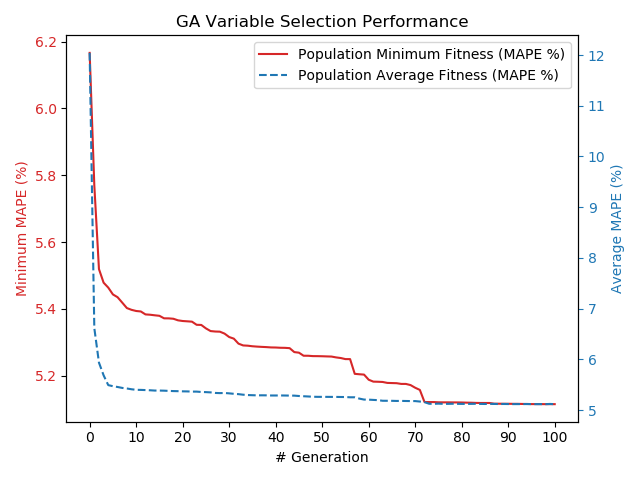

In [8]:
from IPython.display import Image
Image(filename=r'C:\Users\Administrator\Dropbox\Misc\INES 8090 Computational Intelligence\HW\HW4\GA.png')

There are `197` variables being selected. The minimum MAPE on the validation period is `5.115%`, which is better than all 285 variables are included in the model.

The selected variables are listed as below:

['Intercept', 'C(hour)[T.2]', 'C(hour)[T.3]', 'C(hour)[T.4]', 'C(hour)[T.5]', 'C(hour)[T.6]', 'C(hour)[T.7]', 'C(hour)[T.8]', 'C(hour)[T.9]', 'C(hour)[T.11]', 'C(hour)[T.12]', 'C(hour)[T.13]', 'C(hour)[T.15]', 'C(hour)[T.17]', 'C(hour)[T.19]', 'C(hour)[T.20]', 'C(hour)[T.21]', 'C(hour)[T.22]', 'C(hour)[T.23]', 'C(hour)[T.24]', 'C(weekday)[T.2]', 'C(weekday)[T.3]', 'C(weekday)[T.4]', 'C(weekday)[T.5]', 'C(weekday)[T.6]', 'C(weekday)[T.7]', 'C(month)[T.3]', 'C(month)[T.5]', 'C(month)[T.6]', 'C(month)[T.8]', 'C(month)[T.9]', 'C(month)[T.10]', 'C(month)[T.11]', 'C(hour)[T.2]:C(weekday)[T.2]', 'C(hour)[T.3]:C(weekday)[T.2]', 'C(hour)[T.4]:C(weekday)[T.2]', 'C(hour)[T.5]:C(weekday)[T.2]', 'C(hour)[T.6]:C(weekday)[T.2]', 'C(hour)[T.7]:C(weekday)[T.2]', 'C(hour)[T.8]:C(weekday)[T.2]', 'C(hour)[T.11]:C(weekday)[T.2]', 'C(hour)[T.13]:C(weekday)[T.2]', 'C(hour)[T.15]:C(weekday)[T.2]', 'C(hour)[T.16]:C(weekday)[T.2]', 'C(hour)[T.18]:C(weekday)[T.2]', 'C(hour)[T.19]:C(weekday)[T.2]', 'C(hour)[T.20]:C(weekday)[T.2]', 'C(hour)[T.22]:C(weekday)[T.2]', 'C(hour)[T.2]:C(weekday)[T.3]', 'C(hour)[T.3]:C(weekday)[T.3]', 'C(hour)[T.5]:C(weekday)[T.3]', 'C(hour)[T.6]:C(weekday)[T.3]', 'C(hour)[T.7]:C(weekday)[T.3]', 'C(hour)[T.8]:C(weekday)[T.3]', 'C(hour)[T.9]:C(weekday)[T.3]', 'C(hour)[T.10]:C(weekday)[T.3]', 'C(hour)[T.11]:C(weekday)[T.3]', 'C(hour)[T.12]:C(weekday)[T.3]', 'C(hour)[T.13]:C(weekday)[T.3]', 'C(hour)[T.14]:C(weekday)[T.3]', 'C(hour)[T.15]:C(weekday)[T.3]', 'C(hour)[T.18]:C(weekday)[T.3]', 'C(hour)[T.19]:C(weekday)[T.3]', 'C(hour)[T.21]:C(weekday)[T.3]', 'C(hour)[T.22]:C(weekday)[T.3]', 'C(hour)[T.23]:C(weekday)[T.3]', 'C(hour)[T.24]:C(weekday)[T.3]', 'C(hour)[T.2]:C(weekday)[T.4]', 'C(hour)[T.3]:C(weekday)[T.4]', 'C(hour)[T.4]:C(weekday)[T.4]', 'C(hour)[T.5]:C(weekday)[T.4]', 'C(hour)[T.6]:C(weekday)[T.4]', 'C(hour)[T.7]:C(weekday)[T.4]', 'C(hour)[T.8]:C(weekday)[T.4]', 'C(hour)[T.9]:C(weekday)[T.4]', 'C(hour)[T.12]:C(weekday)[T.4]', 'C(hour)[T.13]:C(weekday)[T.4]', 'C(hour)[T.18]:C(weekday)[T.4]', 'C(hour)[T.19]:C(weekday)[T.4]', 'C(hour)[T.20]:C(weekday)[T.4]', 'C(hour)[T.21]:C(weekday)[T.4]', 'C(hour)[T.2]:C(weekday)[T.5]', 'C(hour)[T.3]:C(weekday)[T.5]', 'C(hour)[T.5]:C(weekday)[T.5]', 'C(hour)[T.6]:C(weekday)[T.5]', 'C(hour)[T.7]:C(weekday)[T.5]', 'C(hour)[T.8]:C(weekday)[T.5]', 'C(hour)[T.9]:C(weekday)[T.5]', 'C(hour)[T.10]:C(weekday)[T.5]', 'C(hour)[T.12]:C(weekday)[T.5]', 'C(hour)[T.13]:C(weekday)[T.5]', 'C(hour)[T.14]:C(weekday)[T.5]', 'C(hour)[T.15]:C(weekday)[T.5]', 'C(hour)[T.19]:C(weekday)[T.5]', 'C(hour)[T.21]:C(weekday)[T.5]', 'C(hour)[T.22]:C(weekday)[T.5]', 'C(hour)[T.24]:C(weekday)[T.5]', 'C(hour)[T.6]:C(weekday)[T.6]', 'C(hour)[T.7]:C(weekday)[T.6]', 'C(hour)[T.8]:C(weekday)[T.6]', 'C(hour)[T.9]:C(weekday)[T.6]', 'C(hour)[T.11]:C(weekday)[T.6]', 'C(hour)[T.16]:C(weekday)[T.6]', 'C(hour)[T.17]:C(weekday)[T.6]', 'C(hour)[T.19]:C(weekday)[T.6]', 'C(hour)[T.20]:C(weekday)[T.6]', 'C(hour)[T.21]:C(weekday)[T.6]', 'C(hour)[T.22]:C(weekday)[T.6]', 'C(hour)[T.23]:C(weekday)[T.6]', 'C(hour)[T.4]:C(weekday)[T.7]', 'C(hour)[T.6]:C(weekday)[T.7]', 'C(hour)[T.7]:C(weekday)[T.7]', 'C(hour)[T.8]:C(weekday)[T.7]', 'C(hour)[T.10]:C(weekday)[T.7]', 'C(hour)[T.11]:C(weekday)[T.7]', 'C(hour)[T.12]:C(weekday)[T.7]', 'C(hour)[T.13]:C(weekday)[T.7]', 'C(hour)[T.15]:C(weekday)[T.7]', 'C(hour)[T.17]:C(weekday)[T.7]', 'C(hour)[T.19]:C(weekday)[T.7]', 'C(hour)[T.20]:C(weekday)[T.7]', 'C(hour)[T.22]:C(weekday)[T.7]', 'C(hour)[T.23]:C(weekday)[T.7]', 'trend', 'T', 'C(month)[T.3]:T', 'C(month)[T.4]:T', 'C(month)[T.6]:T', 'C(month)[T.7]:T', 'C(month)[T.9]:T', 'C(month)[T.10]:T', 'C(month)[T.11]:T', 'C(hour)[T.2]:T', 'C(hour)[T.3]:T', 'C(hour)[T.4]:T', 'C(hour)[T.5]:T', 'C(hour)[T.6]:T', 'C(hour)[T.7]:T', 'C(hour)[T.8]:T', 'C(hour)[T.9]:T', 'C(hour)[T.10]:T', 'C(hour)[T.11]:T', 'C(hour)[T.12]:T', 'C(hour)[T.13]:T', 'C(hour)[T.14]:T', 'C(hour)[T.15]:T', 'C(hour)[T.16]:T', 'C(hour)[T.17]:T', 'C(hour)[T.18]:T', 'C(hour)[T.19]:T', 'C(hour)[T.21]:T', 'C(hour)[T.24]:T', 'C(month)[T.5]:I(T ** 2)', 'C(month)[T.6]:I(T ** 2)', 'C(month)[T.7]:I(T ** 2)', 'C(month)[T.9]:I(T ** 2)', 'C(month)[T.10]:I(T ** 2)', 'C(month)[T.11]:I(T ** 2)', 'C(hour)[T.2]:I(T ** 2)', 'C(hour)[T.3]:I(T ** 2)', 'C(hour)[T.5]:I(T ** 2)', 'C(hour)[T.6]:I(T ** 2)', 'C(hour)[T.8]:I(T ** 2)', 'C(hour)[T.10]:I(T ** 2)', 'C(hour)[T.11]:I(T ** 2)', 'C(hour)[T.12]:I(T ** 2)', 'C(hour)[T.13]:I(T ** 2)', 'C(hour)[T.14]:I(T ** 2)', 'C(hour)[T.15]:I(T ** 2)', 'C(hour)[T.16]:I(T ** 2)', 'C(hour)[T.17]:I(T ** 2)', 'C(hour)[T.18]:I(T ** 2)', 'C(hour)[T.19]:I(T ** 2)', 'C(hour)[T.20]:I(T ** 2)', 'I(T ** 3)', 'C(month)[T.3]:I(T ** 3)', 'C(month)[T.4]:I(T ** 3)', 'C(month)[T.8]:I(T ** 3)', 'C(month)[T.9]:I(T ** 3)', 'C(month)[T.10]:I(T ** 3)', 'C(month)[T.11]:I(T ** 3)', 'C(hour)[T.2]:I(T ** 3)', 'C(hour)[T.3]:I(T ** 3)', 'C(hour)[T.4]:I(T ** 3)', 'C(hour)[T.5]:I(T ** 3)', 'C(hour)[T.7]:I(T ** 3)', 'C(hour)[T.8]:I(T ** 3)', 'C(hour)[T.9]:I(T ** 3)', 'C(hour)[T.10]:I(T ** 3)', 'C(hour)[T.13]:I(T ** 3)', 'C(hour)[T.15]:I(T ** 3)', 'C(hour)[T.17]:I(T ** 3)', 'C(hour)[T.18]:I(T ** 3)', 'C(hour)[T.19]:I(T ** 3)', 'C(hour)[T.20]:I(T ** 3)', 'C(hour)[T.22]:I(T ** 3)', 'C(hour)[T.23]:I(T ** 3)']

### ACO for Variable Selection

The idea of using ACO for variable selection is to binary code each ant as a combination of variables and send a group of ants at the beginning of each iteration based on the past iteration's pheromone. The basic idea is the ant leading to the better MAPE performance on the validation period will lead to the variables within that ant being more likely to be selected in the next iterations. 

The implementation highlights are listed below:
* Conduct binary encoding to each ant. A position coded as "1" denotes the corresponding variable has been added to the model. A position coded as "0" denotes the corresponding variable has been removed from the model.
* The inverse of the MAPE on validation period for each ant (variable combination) will serve as the amount of pheromone that's left behind. 
* The pheromone collected for an iteration is calculated by normalizing and aggregating the pheromone left by each individual ant
* The total pheromone up until the end of an iteration is calculated by conducting a weighted average of the pheromone collected from the past iterations and the pheromone collected from the current iteration. 
* The total pheromone will serve as an input to the next iteration. 

Also, I've been having convergence issue using the vanilla ACO for this exercise. Implementing an `Elitist Ant System (EAS)` solves the problem by introducing the elitist ant (the variable combination results in lowest MAPE in a iteration). The elitist ant will leave `28` times _more_ pheromone than the rest of the population, which helps the algorithm to converge at a lower iteration. 

The following parameters has been initialized:
* Size/dimension of ant: `285`. This matches the total amount of candidate variables.
* Population size at each iteration: `100`. This determines how many ants will be sent out at the beginning of each iteration. Larger this number, the more computation power will be required. 
* Num of Iteration: `50`. This is the total amount of iteration that the algorithm will run.
* Evaporation rate: `0`. This determines the speed of pheromone being evaporated after each iteration. It has been set to 0 after trial and error. 

Below gives the plot of the training results. We have run in total of `50` iterations, while The dashed magenta line gives the average MAPE of the ant population at each iteration and the solid blue line gives the best MAPE of the ant population at each iteration. We can see that the algorithm is able to converge fast after introducing the "Elitist Ant" and the entire population has been leading to better solutions starting from the first few iterations.

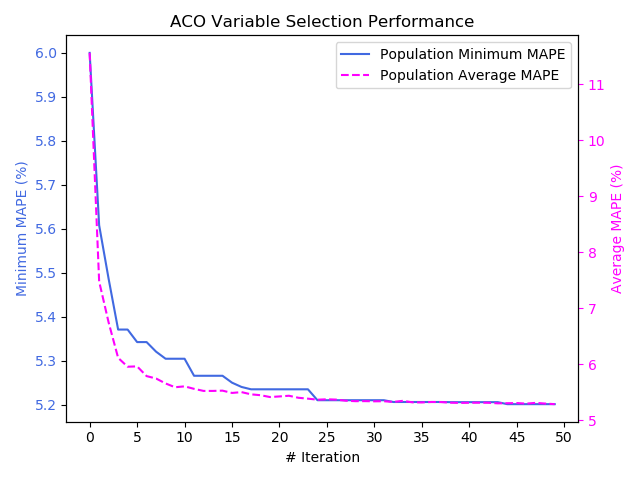

In [9]:
from IPython.display import Image
Image(filename=r'C:\Users\Administrator\Dropbox\Misc\INES 8090 Computational Intelligence\HW\HW4\ACO.png')

There are `243` variables being selected. The minimum MAPE on the validation period is `5.201%`, which is better than all 285 variables are included in the model. 

The selected variables are listed as below:

['Intercept', 'C(hour)[T.2]', 'C(hour)[T.3]', 'C(hour)[T.5]', 'C(hour)[T.7]', 'C(hour)[T.8]', 'C(hour)[T.9]', 'C(hour)[T.12]', 'C(hour)[T.13]', 'C(hour)[T.14]', 'C(hour)[T.15]', 'C(hour)[T.16]', 'C(hour)[T.17]', 'C(hour)[T.18]', 'C(hour)[T.20]', 'C(hour)[T.21]', 'C(hour)[T.22]', 'C(hour)[T.23]', 'C(hour)[T.24]', 'C(weekday)[T.2]', 'C(weekday)[T.3]', 'C(weekday)[T.4]', 'C(weekday)[T.5]', 'C(weekday)[T.6]', 'C(weekday)[T.7]', 'C(month)[T.2]', 'C(month)[T.8]', 'C(month)[T.9]', 'C(month)[T.10]', 'C(month)[T.11]', 'C(month)[T.12]', 'C(hour)[T.2]:C(weekday)[T.2]', 'C(hour)[T.3]:C(weekday)[T.2]', 'C(hour)[T.4]:C(weekday)[T.2]', 'C(hour)[T.5]:C(weekday)[T.2]', 'C(hour)[T.6]:C(weekday)[T.2]', 'C(hour)[T.7]:C(weekday)[T.2]', 'C(hour)[T.8]:C(weekday)[T.2]', 'C(hour)[T.9]:C(weekday)[T.2]', 'C(hour)[T.10]:C(weekday)[T.2]', 'C(hour)[T.11]:C(weekday)[T.2]', 'C(hour)[T.13]:C(weekday)[T.2]', 'C(hour)[T.14]:C(weekday)[T.2]', 'C(hour)[T.15]:C(weekday)[T.2]', 'C(hour)[T.18]:C(weekday)[T.2]', 'C(hour)[T.19]:C(weekday)[T.2]', 'C(hour)[T.20]:C(weekday)[T.2]', 'C(hour)[T.21]:C(weekday)[T.2]', 'C(hour)[T.22]:C(weekday)[T.2]', 'C(hour)[T.24]:C(weekday)[T.2]', 'C(hour)[T.2]:C(weekday)[T.3]', 'C(hour)[T.3]:C(weekday)[T.3]', 'C(hour)[T.4]:C(weekday)[T.3]', 'C(hour)[T.5]:C(weekday)[T.3]', 'C(hour)[T.6]:C(weekday)[T.3]', 'C(hour)[T.7]:C(weekday)[T.3]', 'C(hour)[T.8]:C(weekday)[T.3]', 'C(hour)[T.9]:C(weekday)[T.3]', 'C(hour)[T.10]:C(weekday)[T.3]', 'C(hour)[T.11]:C(weekday)[T.3]', 'C(hour)[T.12]:C(weekday)[T.3]', 'C(hour)[T.13]:C(weekday)[T.3]', 'C(hour)[T.14]:C(weekday)[T.3]', 'C(hour)[T.16]:C(weekday)[T.3]', 'C(hour)[T.17]:C(weekday)[T.3]', 'C(hour)[T.19]:C(weekday)[T.3]', 'C(hour)[T.20]:C(weekday)[T.3]', 'C(hour)[T.21]:C(weekday)[T.3]', 'C(hour)[T.22]:C(weekday)[T.3]', 'C(hour)[T.23]:C(weekday)[T.3]', 'C(hour)[T.24]:C(weekday)[T.3]', 'C(hour)[T.2]:C(weekday)[T.4]', 'C(hour)[T.3]:C(weekday)[T.4]', 'C(hour)[T.4]:C(weekday)[T.4]', 'C(hour)[T.5]:C(weekday)[T.4]', 'C(hour)[T.6]:C(weekday)[T.4]', 'C(hour)[T.7]:C(weekday)[T.4]', 'C(hour)[T.8]:C(weekday)[T.4]', 'C(hour)[T.9]:C(weekday)[T.4]', 'C(hour)[T.10]:C(weekday)[T.4]', 'C(hour)[T.12]:C(weekday)[T.4]', 'C(hour)[T.13]:C(weekday)[T.4]', 'C(hour)[T.14]:C(weekday)[T.4]', 'C(hour)[T.15]:C(weekday)[T.4]', 'C(hour)[T.16]:C(weekday)[T.4]', 'C(hour)[T.17]:C(weekday)[T.4]', 'C(hour)[T.18]:C(weekday)[T.4]', 'C(hour)[T.19]:C(weekday)[T.4]', 'C(hour)[T.20]:C(weekday)[T.4]', 'C(hour)[T.21]:C(weekday)[T.4]', 'C(hour)[T.23]:C(weekday)[T.4]', 'C(hour)[T.24]:C(weekday)[T.4]', 'C(hour)[T.2]:C(weekday)[T.5]', 'C(hour)[T.3]:C(weekday)[T.5]', 'C(hour)[T.4]:C(weekday)[T.5]', 'C(hour)[T.5]:C(weekday)[T.5]', 'C(hour)[T.6]:C(weekday)[T.5]', 'C(hour)[T.7]:C(weekday)[T.5]', 'C(hour)[T.8]:C(weekday)[T.5]', 'C(hour)[T.10]:C(weekday)[T.5]', 'C(hour)[T.11]:C(weekday)[T.5]', 'C(hour)[T.12]:C(weekday)[T.5]', 'C(hour)[T.13]:C(weekday)[T.5]', 'C(hour)[T.14]:C(weekday)[T.5]', 'C(hour)[T.15]:C(weekday)[T.5]', 'C(hour)[T.17]:C(weekday)[T.5]', 'C(hour)[T.18]:C(weekday)[T.5]', 'C(hour)[T.19]:C(weekday)[T.5]', 'C(hour)[T.20]:C(weekday)[T.5]', 'C(hour)[T.23]:C(weekday)[T.5]', 'C(hour)[T.2]:C(weekday)[T.6]', 'C(hour)[T.4]:C(weekday)[T.6]', 'C(hour)[T.5]:C(weekday)[T.6]', 'C(hour)[T.6]:C(weekday)[T.6]', 'C(hour)[T.7]:C(weekday)[T.6]', 'C(hour)[T.8]:C(weekday)[T.6]', 'C(hour)[T.9]:C(weekday)[T.6]', 'C(hour)[T.10]:C(weekday)[T.6]', 'C(hour)[T.12]:C(weekday)[T.6]', 'C(hour)[T.13]:C(weekday)[T.6]', 'C(hour)[T.14]:C(weekday)[T.6]', 'C(hour)[T.15]:C(weekday)[T.6]', 'C(hour)[T.16]:C(weekday)[T.6]', 'C(hour)[T.17]:C(weekday)[T.6]', 'C(hour)[T.18]:C(weekday)[T.6]', 'C(hour)[T.19]:C(weekday)[T.6]', 'C(hour)[T.21]:C(weekday)[T.6]', 'C(hour)[T.23]:C(weekday)[T.6]', 'C(hour)[T.24]:C(weekday)[T.6]', 'C(hour)[T.4]:C(weekday)[T.7]', 'C(hour)[T.5]:C(weekday)[T.7]', 'C(hour)[T.6]:C(weekday)[T.7]', 'C(hour)[T.7]:C(weekday)[T.7]', 'C(hour)[T.10]:C(weekday)[T.7]', 'C(hour)[T.11]:C(weekday)[T.7]', 'C(hour)[T.12]:C(weekday)[T.7]', 'C(hour)[T.13]:C(weekday)[T.7]', 'C(hour)[T.14]:C(weekday)[T.7]', 'C(hour)[T.15]:C(weekday)[T.7]', 'C(hour)[T.16]:C(weekday)[T.7]', 'C(hour)[T.17]:C(weekday)[T.7]', 'C(hour)[T.19]:C(weekday)[T.7]', 'C(hour)[T.20]:C(weekday)[T.7]', 'C(hour)[T.21]:C(weekday)[T.7]', 'C(hour)[T.22]:C(weekday)[T.7]', 'C(hour)[T.23]:C(weekday)[T.7]', 'C(hour)[T.24]:C(weekday)[T.7]', 'trend', 'T', 'C(month)[T.2]:T', 'C(month)[T.3]:T', 'C(month)[T.4]:T', 'C(month)[T.5]:T', 'C(month)[T.6]:T', 'C(month)[T.7]:T', 'C(month)[T.8]:T', 'C(month)[T.9]:T', 'C(month)[T.10]:T', 'C(month)[T.11]:T', 'C(month)[T.12]:T', 'C(hour)[T.2]:T', 'C(hour)[T.3]:T', 'C(hour)[T.4]:T', 'C(hour)[T.5]:T', 'C(hour)[T.6]:T', 'C(hour)[T.7]:T', 'C(hour)[T.8]:T', 'C(hour)[T.9]:T', 'C(hour)[T.10]:T', 'C(hour)[T.11]:T', 'C(hour)[T.12]:T', 'C(hour)[T.13]:T', 'C(hour)[T.14]:T', 'C(hour)[T.15]:T', 'C(hour)[T.16]:T', 'C(hour)[T.17]:T', 'C(hour)[T.18]:T', 'C(hour)[T.19]:T', 'C(hour)[T.20]:T', 'C(hour)[T.21]:T', 'C(hour)[T.23]:T', 'C(hour)[T.24]:T', 'I(T ** 2)', 'C(month)[T.2]:I(T ** 2)', 'C(month)[T.3]:I(T ** 2)', 'C(month)[T.4]:I(T ** 2)', 'C(month)[T.5]:I(T ** 2)', 'C(month)[T.6]:I(T ** 2)', 'C(month)[T.7]:I(T ** 2)', 'C(month)[T.8]:I(T ** 2)', 'C(month)[T.9]:I(T ** 2)', 'C(month)[T.10]:I(T ** 2)', 'C(month)[T.11]:I(T ** 2)', 'C(month)[T.12]:I(T ** 2)', 'C(hour)[T.2]:I(T ** 2)', 'C(hour)[T.4]:I(T ** 2)', 'C(hour)[T.5]:I(T ** 2)', 'C(hour)[T.7]:I(T ** 2)', 'C(hour)[T.8]:I(T ** 2)', 'C(hour)[T.9]:I(T ** 2)', 'C(hour)[T.11]:I(T ** 2)', 'C(hour)[T.12]:I(T ** 2)', 'C(hour)[T.14]:I(T ** 2)', 'C(hour)[T.15]:I(T ** 2)', 'C(hour)[T.16]:I(T ** 2)', 'C(hour)[T.17]:I(T ** 2)', 'C(hour)[T.18]:I(T ** 2)', 'C(hour)[T.19]:I(T ** 2)', 'C(hour)[T.20]:I(T ** 2)', 'C(hour)[T.21]:I(T ** 2)', 'C(hour)[T.22]:I(T ** 2)', 'C(hour)[T.24]:I(T ** 2)', 'I(T ** 3)', 'C(month)[T.2]:I(T ** 3)', 'C(month)[T.3]:I(T ** 3)', 'C(month)[T.4]:I(T ** 3)', 'C(month)[T.6]:I(T ** 3)', 'C(month)[T.8]:I(T ** 3)', 'C(month)[T.9]:I(T ** 3)', 'C(month)[T.10]:I(T ** 3)', 'C(month)[T.11]:I(T ** 3)', 'C(month)[T.12]:I(T ** 3)', 'C(hour)[T.2]:I(T ** 3)', 'C(hour)[T.3]:I(T ** 3)', 'C(hour)[T.4]:I(T ** 3)', 'C(hour)[T.6]:I(T ** 3)', 'C(hour)[T.7]:I(T ** 3)', 'C(hour)[T.8]:I(T ** 3)', 'C(hour)[T.9]:I(T ** 3)', 'C(hour)[T.10]:I(T ** 3)', 'C(hour)[T.12]:I(T ** 3)', 'C(hour)[T.13]:I(T ** 3)', 'C(hour)[T.14]:I(T ** 3)', 'C(hour)[T.15]:I(T ** 3)', 'C(hour)[T.16]:I(T ** 3)', 'C(hour)[T.17]:I(T ** 3)', 'C(hour)[T.18]:I(T ** 3)', 'C(hour)[T.19]:I(T ** 3)', 'C(hour)[T.20]:I(T ** 3)', 'C(hour)[T.21]:I(T ** 3)', 'C(hour)[T.22]:I(T ** 3)', 'C(hour)[T.23]:I(T ** 3)', 'C(hour)[T.24]:I(T ** 3)']

### PSO for Variable Selection

The basic idea of using PSO for variable selection is to leverage binary encoding for each particle to represent the models with a combination of variables. The movement(speed) of each particle will be directed by the initialization speed (random number with constraint, $smax$ and $smin$), the best history of this particle ($pbest$) and the best record for the entire particle population ($gbest$). 

The initial population will start from `40` particles and the 285 elements (the total num of candidate variables) within each particle will be initialized with random numbers between 0 and 1. 

Then the elements within each particle will be rounded to 0/1 before the training step. After each iteration, the $pbest$ and $gbest$ will be updated accordingly based on the MAPE on the validation period for each particle. The speed of each particle will get updated and controled by several parameters:
* Weight parameter $w$. Here the linearly decreasing weight has been used, with w_ini=0.9, w_end=0.3. This is to encourange exploration at the beginning iterations and encourage exploration at the later iterations. 
* Exploration constant: $c_1$. Here $c_1$ has been coded as 2.
* Exploitation constant: $c_2$. Here $c_2$ has been coded as 2.5. Notice that here the $c_2>c_1$ and we emphasize more from effect of exploitation. This will help our algorithm converge faster.

The speed limit are also extremely important to this algorithm. A larger speed limit can cause faster convergence but might lead to the factor that the particles will miss the optimal solution. A lower speed limit may cause a slower convergence. Here:
* $smin=-0.49$
* $smax=0.49$

Below gives the plot of the training results. We have run in total of `50` iterations, while the dashed magenta line gives the average MAPE of the particle population at each iteration and the solid blue line gives the best MAPE of the particle population at each iteration. We can see that at the beginning, both curves are fluctuating wildly since the bigger the weight parameter encourages the particles to explore in the search space. The fluctuation goes down significantly after 40 iterations and the best MAPE at each iteration also becomes stabilized. 

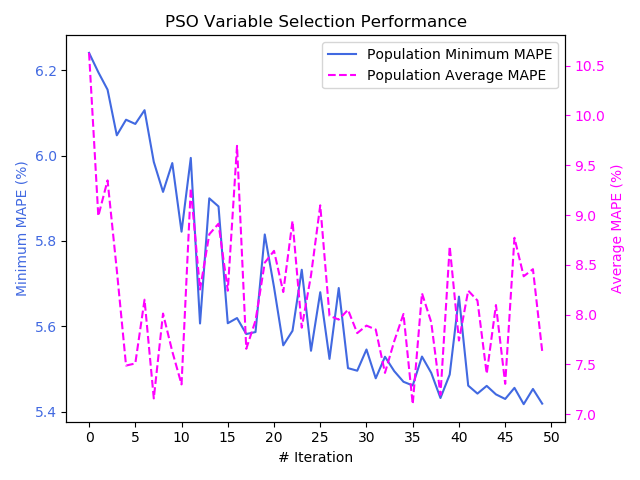

In [3]:
from IPython.display import Image
Image(filename=r'C:\Users\Administrator\Dropbox\Misc\INES 8090 Computational Intelligence\HW\HW4\PSO.png')

There are `178` variables being selected. The minimum MAPE on the validation period is `5.418%`. 

The selected variables are listed as below:

['Intercept', 'C(hour)[T.2]', 'C(hour)[T.6]', 'C(hour)[T.8]', 'C(hour)[T.12]', 'C(hour)[T.14]', 'C(hour)[T.16]', 'C(hour)[T.17]', 'C(hour)[T.18]', 'C(hour)[T.19]', 'C(hour)[T.20]', 'C(hour)[T.21]', 'C(hour)[T.22]', 'C(hour)[T.23]', 'C(weekday)[T.2]', 'C(weekday)[T.3]', 'C(weekday)[T.4]', 'C(weekday)[T.5]', 'C(month)[T.2]', 'C(month)[T.3]', 'C(month)[T.5]', 'C(month)[T.7]', 'C(month)[T.8]', 'C(hour)[T.3]:C(weekday)[T.2]', 'C(hour)[T.4]:C(weekday)[T.2]', 'C(hour)[T.5]:C(weekday)[T.2]', 'C(hour)[T.6]:C(weekday)[T.2]', 'C(hour)[T.8]:C(weekday)[T.2]', 'C(hour)[T.10]:C(weekday)[T.2]', 'C(hour)[T.13]:C(weekday)[T.2]', 'C(hour)[T.14]:C(weekday)[T.2]', 'C(hour)[T.16]:C(weekday)[T.2]', 'C(hour)[T.19]:C(weekday)[T.2]', 'C(hour)[T.21]:C(weekday)[T.2]', 'C(hour)[T.22]:C(weekday)[T.2]', 'C(hour)[T.23]:C(weekday)[T.2]', 'C(hour)[T.24]:C(weekday)[T.2]', 'C(hour)[T.3]:C(weekday)[T.3]', 'C(hour)[T.4]:C(weekday)[T.3]', 'C(hour)[T.5]:C(weekday)[T.3]', 'C(hour)[T.7]:C(weekday)[T.3]', 'C(hour)[T.8]:C(weekday)[T.3]', 'C(hour)[T.10]:C(weekday)[T.3]', 'C(hour)[T.11]:C(weekday)[T.3]', 'C(hour)[T.14]:C(weekday)[T.3]', 'C(hour)[T.15]:C(weekday)[T.3]', 'C(hour)[T.16]:C(weekday)[T.3]', 'C(hour)[T.18]:C(weekday)[T.3]', 'C(hour)[T.19]:C(weekday)[T.3]', 'C(hour)[T.24]:C(weekday)[T.3]', 'C(hour)[T.3]:C(weekday)[T.4]', 'C(hour)[T.4]:C(weekday)[T.4]', 'C(hour)[T.7]:C(weekday)[T.4]', 'C(hour)[T.10]:C(weekday)[T.4]', 'C(hour)[T.11]:C(weekday)[T.4]', 'C(hour)[T.14]:C(weekday)[T.4]', 'C(hour)[T.15]:C(weekday)[T.4]', 'C(hour)[T.17]:C(weekday)[T.4]', 'C(hour)[T.18]:C(weekday)[T.4]', 'C(hour)[T.19]:C(weekday)[T.4]', 'C(hour)[T.20]:C(weekday)[T.4]', 'C(hour)[T.21]:C(weekday)[T.4]', 'C(hour)[T.23]:C(weekday)[T.4]', 'C(hour)[T.24]:C(weekday)[T.4]', 'C(hour)[T.2]:C(weekday)[T.5]', 'C(hour)[T.3]:C(weekday)[T.5]', 'C(hour)[T.4]:C(weekday)[T.5]', 'C(hour)[T.5]:C(weekday)[T.5]', 'C(hour)[T.6]:C(weekday)[T.5]', 'C(hour)[T.7]:C(weekday)[T.5]', 'C(hour)[T.8]:C(weekday)[T.5]', 'C(hour)[T.9]:C(weekday)[T.5]', 'C(hour)[T.13]:C(weekday)[T.5]', 'C(hour)[T.15]:C(weekday)[T.5]', 'C(hour)[T.16]:C(weekday)[T.5]', 'C(hour)[T.17]:C(weekday)[T.5]', 'C(hour)[T.19]:C(weekday)[T.5]', 'C(hour)[T.20]:C(weekday)[T.5]', 'C(hour)[T.21]:C(weekday)[T.5]', 'C(hour)[T.23]:C(weekday)[T.5]', 'C(hour)[T.24]:C(weekday)[T.5]', 'C(hour)[T.2]:C(weekday)[T.6]', 'C(hour)[T.5]:C(weekday)[T.6]', 'C(hour)[T.6]:C(weekday)[T.6]', 'C(hour)[T.7]:C(weekday)[T.6]', 'C(hour)[T.8]:C(weekday)[T.6]', 'C(hour)[T.9]:C(weekday)[T.6]', 'C(hour)[T.11]:C(weekday)[T.6]', 'C(hour)[T.12]:C(weekday)[T.6]', 'C(hour)[T.13]:C(weekday)[T.6]', 'C(hour)[T.15]:C(weekday)[T.6]', 'C(hour)[T.16]:C(weekday)[T.6]', 'C(hour)[T.18]:C(weekday)[T.6]', 'C(hour)[T.19]:C(weekday)[T.6]', 'C(hour)[T.20]:C(weekday)[T.6]', 'C(hour)[T.21]:C(weekday)[T.6]', 'C(hour)[T.24]:C(weekday)[T.6]', 'C(hour)[T.2]:C(weekday)[T.7]', 'C(hour)[T.4]:C(weekday)[T.7]', 'C(hour)[T.10]:C(weekday)[T.7]', 'C(hour)[T.12]:C(weekday)[T.7]', 'C(hour)[T.14]:C(weekday)[T.7]', 'C(hour)[T.15]:C(weekday)[T.7]', 'C(hour)[T.17]:C(weekday)[T.7]', 'C(hour)[T.20]:C(weekday)[T.7]', 'C(hour)[T.21]:C(weekday)[T.7]', 'C(hour)[T.22]:C(weekday)[T.7]', 'C(hour)[T.23]:C(weekday)[T.7]', 'C(hour)[T.24]:C(weekday)[T.7]', 'trend', 'T', 'C(month)[T.2]:T', 'C(month)[T.3]:T', 'C(month)[T.6]:T', 'C(month)[T.7]:T', 'C(month)[T.8]:T', 'C(month)[T.9]:T', 'C(hour)[T.2]:T', 'C(hour)[T.4]:T', 'C(hour)[T.9]:T', 'C(hour)[T.10]:T', 'C(hour)[T.12]:T', 'C(hour)[T.13]:T', 'C(hour)[T.16]:T', 'C(hour)[T.17]:T', 'C(hour)[T.19]:T', 'C(hour)[T.20]:T', 'C(hour)[T.22]:T', 'I(T ** 2)', 'C(month)[T.2]:I(T ** 2)', 'C(month)[T.3]:I(T ** 2)', 'C(month)[T.4]:I(T ** 2)', 'C(month)[T.6]:I(T ** 2)', 'C(month)[T.7]:I(T ** 2)', 'C(month)[T.8]:I(T ** 2)', 'C(month)[T.10]:I(T ** 2)', 'C(month)[T.11]:I(T ** 2)', 'C(hour)[T.2]:I(T ** 2)', 'C(hour)[T.3]:I(T ** 2)', 'C(hour)[T.5]:I(T ** 2)', 'C(hour)[T.6]:I(T ** 2)', 'C(hour)[T.7]:I(T ** 2)', 'C(hour)[T.8]:I(T ** 2)', 'C(hour)[T.9]:I(T ** 2)', 'C(hour)[T.10]:I(T ** 2)', 'C(hour)[T.11]:I(T ** 2)', 'C(hour)[T.13]:I(T ** 2)', 'C(hour)[T.14]:I(T ** 2)', 'C(hour)[T.15]:I(T ** 2)', 'C(hour)[T.16]:I(T ** 2)', 'C(hour)[T.17]:I(T ** 2)', 'C(hour)[T.18]:I(T ** 2)', 'C(hour)[T.20]:I(T ** 2)', 'C(hour)[T.21]:I(T ** 2)', 'C(hour)[T.22]:I(T ** 2)', 'I(T ** 3)', 'C(month)[T.3]:I(T ** 3)', 'C(month)[T.4]:I(T ** 3)', 'C(month)[T.5]:I(T ** 3)', 'C(month)[T.7]:I(T ** 3)', 'C(month)[T.9]:I(T ** 3)', 'C(month)[T.10]:I(T ** 3)', 'C(month)[T.11]:I(T ** 3)', 'C(hour)[T.2]:I(T ** 3)', 'C(hour)[T.3]:I(T ** 3)', 'C(hour)[T.5]:I(T ** 3)', 'C(hour)[T.7]:I(T ** 3)', 'C(hour)[T.8]:I(T ** 3)', 'C(hour)[T.9]:I(T ** 3)', 'C(hour)[T.11]:I(T ** 3)', 'C(hour)[T.12]:I(T ** 3)', 'C(hour)[T.14]:I(T ** 3)', 'C(hour)[T.15]:I(T ** 3)', 'C(hour)[T.17]:I(T ** 3)', 'C(hour)[T.18]:I(T ** 3)', 'C(hour)[T.21]:I(T ** 3)', 'C(hour)[T.23]:I(T ** 3)', 'C(hour)[T.24]:I(T ** 3)']

## Q3 Discussion

Discussions about each individual methods have been made in the subsections of Q2. Here we will compare the number of parameters being selected by each method and their MAPE performance on the validation period. The benchmark has been set as including all 285 variables in the model. 

The stepwise regression selects the least amount of parameters and leads to the worse MAPE. This is because stepwise regression is a heuristic that can easily fall into the local minima. 

GA, ACO and PSO all lead to better MAPE result, while GA and ACO are able to beat the benchmark performance. Also all of the 3 methods can leverage the multiprocessing and fasten the training process. 

| Method Name | # of Iteration | Population Size | # of parameters selected | Validation MAPE(%) |
|:--- |:---:|:---:|:---:|:---|
| Benchmark | NA | NA | 285 |  5.221 |
| Stepwise Regression | 16 | 1 | 13 |  8.955 |
| GA | 100 | 80 | 197 |  **5.117** |
| ACO | 50 | 100 | 231 | **5.201** |
| PSO | 50 | 40|  178 |  5.418 |